# TEMA 2 - IA

In [146]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.impute as imp
import sklearn.preprocessing as pre
import sklearn.model_selection as ms
import sklearn.metrics as met
import sklearn.linear_model as lm
import sklearn.neural_network as nn
import sklearn.base as base
import imblearn.over_sampling as over
import typing as tp
import warnings
from sklearn.exceptions import ConvergenceWarning

## 1. Explorarea Datelor

### Utils

In [147]:
def plot_category_features(data: pd.DataFrame, features: list[str]):
    _, axs = plt.subplots(len(features), figsize=(10, 5 * len(features)))

    for i, feature in enumerate(features):
        counts = data[feature].value_counts()
        counts.plot(kind='bar', ax=axs[i], color='skyblue')
        axs[i].xaxis.set_tick_params(rotation=45)
        axs[i].set_title(feature)
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Count')
        
        for x, y in enumerate(counts):
            axs[i].text(x, y, str(y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [148]:
def show_boxplot(data: pd.DataFrame, features: list[str]):
    fig, axs = plt.subplots(len(features), 1, figsize=(10, 5 * len(features)))
    for i, feature in enumerate(features):
        axs[i].boxplot(data[feature].dropna())
        axs[i].set_title(feature)
        axs[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

In [149]:
def plot_target_feature(train_data: pd.DataFrame, test_data: pd.DataFrame, full_data: pd.DataFrame, target_feature: str):
    train_target_freq = train_data[target_feature].value_counts(normalize=True)
    test_target_freq = test_data[target_feature].value_counts(normalize=True)
    full_target_freq = full_data[target_feature].value_counts(normalize=True)

    target_freq_data = pd.DataFrame({'Train': train_target_freq,
                                   'Test': test_target_freq,
                                   'Full': full_target_freq})

    target_freq_data.plot.bar(color=['skyblue', 'red', 'green'])
    plt.xlabel('Target Feature')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of {target_feature} in Train/Test/Full Datasets')
    plt.show()

In [150]:
def plot_correlation_continuous_data(data: pd.DataFrame):
    corr_matrix = data.corr()
    display(corr_matrix)
    
    plt.matshow(corr_matrix, cmap='coolwarm')
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns.to_list(), rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns.to_list())
    plt.colorbar()

    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            plt.text(i, j, str(corr_matrix.iloc[i, j].round(2)), ha='center', va='center', color='w') # type: ignore
    plt.show()

In [151]:
def plot_correlation_category_data(data : pd.DataFrame):
    corr_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
    for i in data.columns:
        for j in data.columns:
            if i == j:
                corr_matrix.loc[i, j] = 1
            else:
                cross_tab = pd.crosstab(data[i], data[j])
                corr_matrix.loc[i, j] = sp.stats.chi2_contingency(cross_tab)[1]

    corr_matrix = corr_matrix.astype(float)
    
    plt.matshow(corr_matrix, cmap='coolwarm')
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns.to_list(), rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns.to_list())
    plt.colorbar()

    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            plt.text(i, j, str(corr_matrix.iloc[i, j].round(2)), ha='center', va='center', color='w') # type: ignore
    plt.show()
    
    

### AVC

In [152]:
# Load the data
avc_full_data : pd.DataFrame = pd.read_csv('data/AVC_full.csv')
avc_train_data : pd.DataFrame = pd.read_csv('data/AVC_train.csv')
avc_test_data : pd.DataFrame = pd.read_csv('data/AVC_test.csv')

# Show the data
avc_full_data.head()

,mean_blood_sugar_level,cardiovascular_issues,job_category,body_mass_indicator,sex,tobacco_usage,high_blood_pressure,married,living_area,years_old,chaotic_sleep,analysis_results,biological_age_index,cerebrovascular_accident
0,228.69,1,private_sector,36.6,M,ex-smoker,0,Y,City,67.0,1,503.662278,181.786614,1
1,202.21,0,entrepreneurial,NaN,F,non-smoker,0,Y,Countryside,61.0,0,503.541654,130.089915,1
2,105.92,1,private_sector,32.5,M,non-smoker,0,Y,Countryside,80.0,1,NaN,201.411374,1
3,171.23,0,private_sector,34.4,F,smoker,0,Y,City,49.0,0,411.618245,171.794024,1
4,174.12,0,entrepreneurial,24.0,F,non-smoker,1,Y,Countryside,79.0,0,450.887478,232.180890,1


In [153]:
# Data types

avc_continuous_features : list[str] = ['mean_blood_sugar_level', 'body_mass_indicator', 'years_old', 'analysis_results', 'biological_age_index']
avc_category_features : list[str] = ['cardiovascular_issues', 'job_category', 'sex', 'tobacco_usage', 'high_blood_pressure', 'married', 'living_area', 'chaotic_sleep', 'cerebrovascular_accident']

avc_target_category : str = 'cerebrovascular_accident'


#### 1.1 Analiza tipului de atribute și a plajei de valori a acestora

##### 1.1a Atribute continue

In [154]:
display(avc_full_data[avc_continuous_features].describe())

,mean_blood_sugar_level,body_mass_indicator,years_old,analysis_results,biological_age_index
count,5110.000000,4909.000000,5110.000000,4599.000000,5110.000000
mean,106.147677,28.893237,46.568665,323.523446,134.784256
std,45.283560,7.854067,26.593912,101.577442,50.399352
min,55.120000,10.300000,0.080000,104.829714,-15.109456
25%,77.245000,23.500000,26.000000,254.646209,96.710581
50%,91.885000,28.100000,47.000000,301.031628,136.374631
75%,114.090000,33.100000,63.750000,362.822769,172.507322
max,271.740000,97.600000,134.000000,756.807975,266.986321


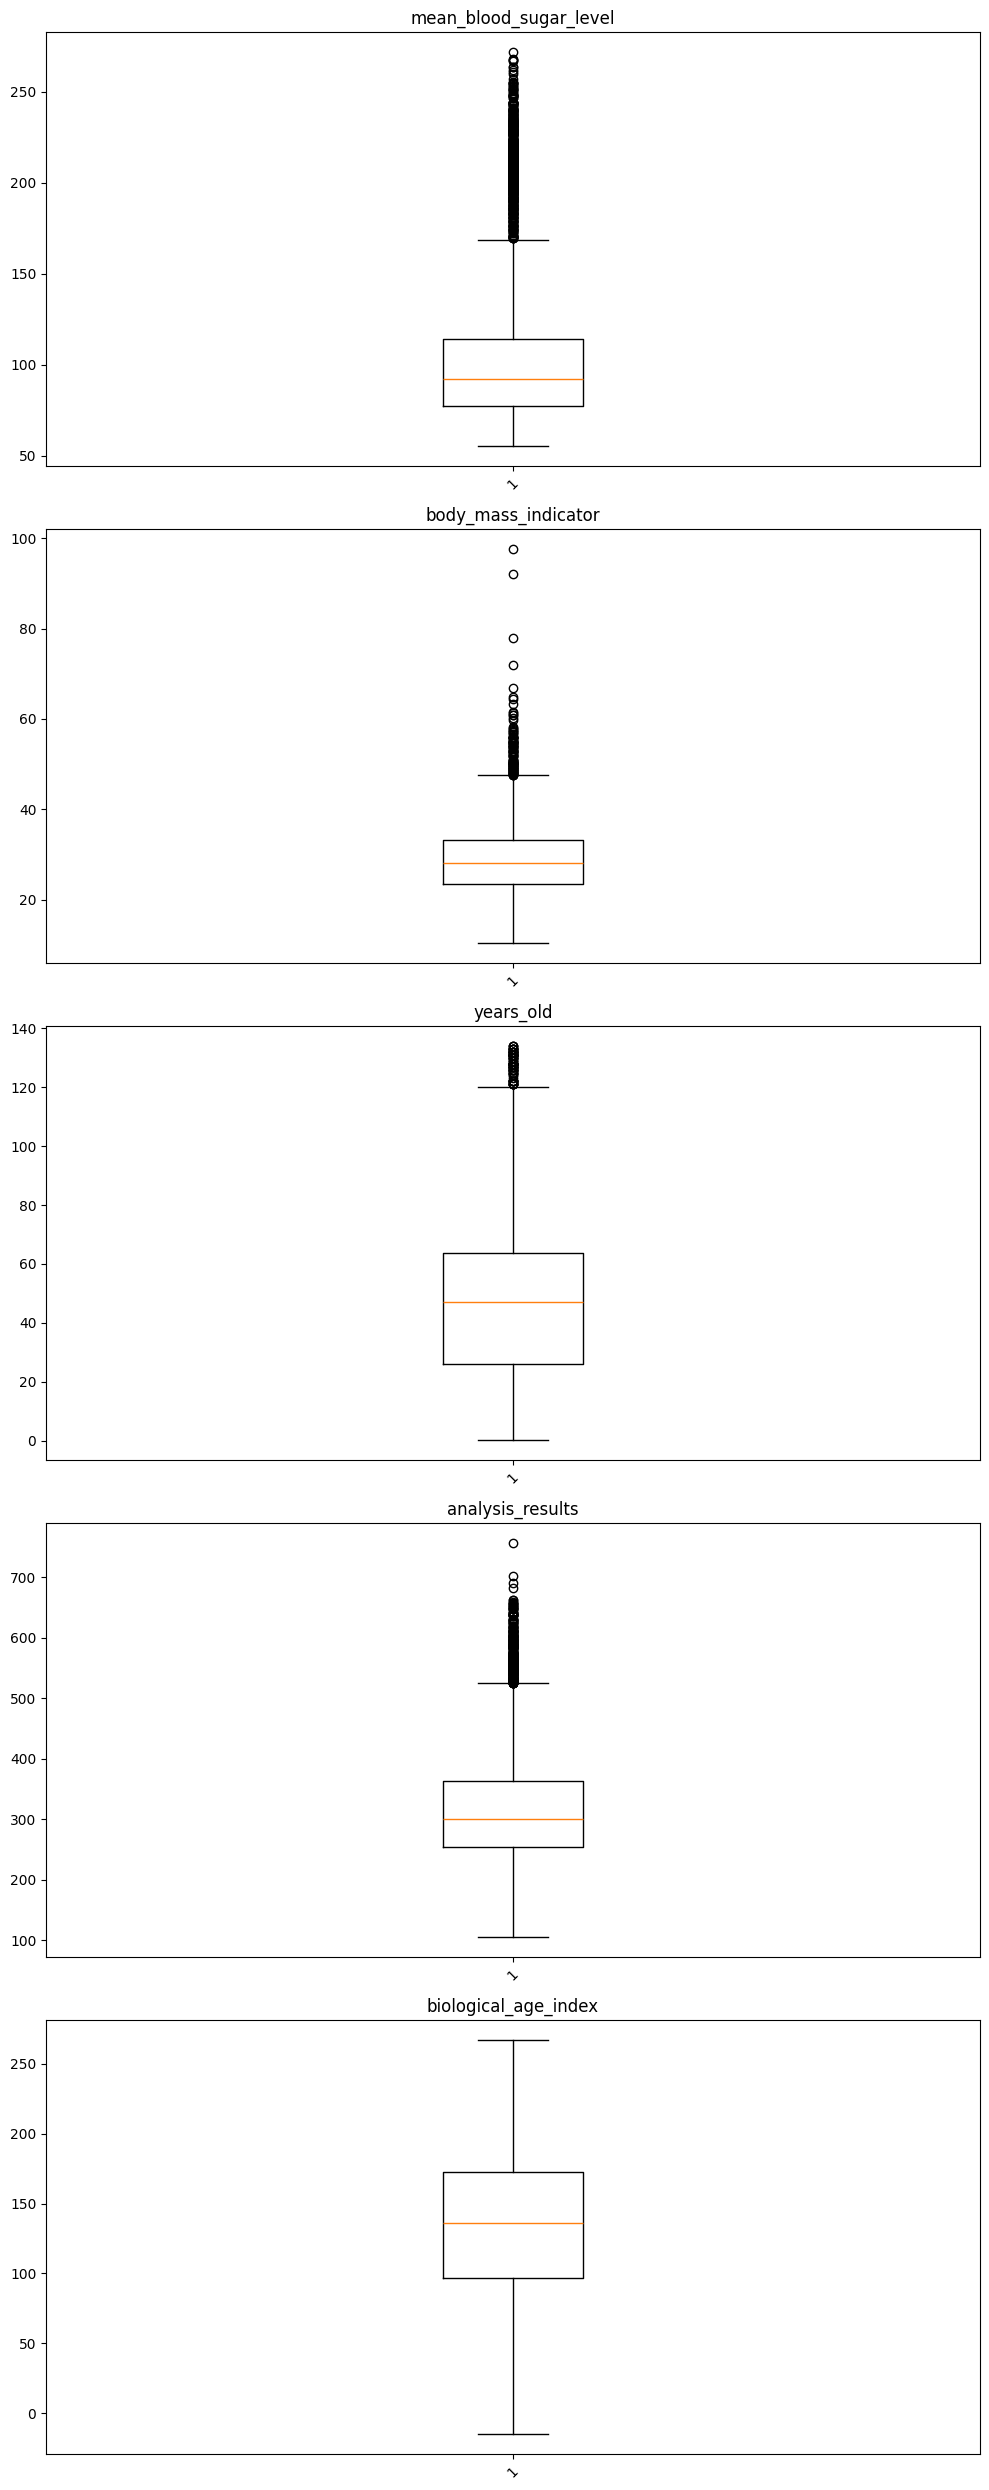

In [155]:
show_boxplot(avc_full_data, avc_continuous_features)

##### 1.1b Atribute discrete

In [156]:
display(pd.DataFrame({'count': avc_full_data[avc_category_features].count(),
                      'unique': avc_full_data[avc_category_features].nunique()}))

,count,unique
cardiovascular_issues,5110,2
job_category,5110,5
sex,5110,2
tobacco_usage,5110,4
high_blood_pressure,5110,2
married,4599,2
living_area,5110,2
chaotic_sleep,5110,2
cerebrovascular_accident,5110,2


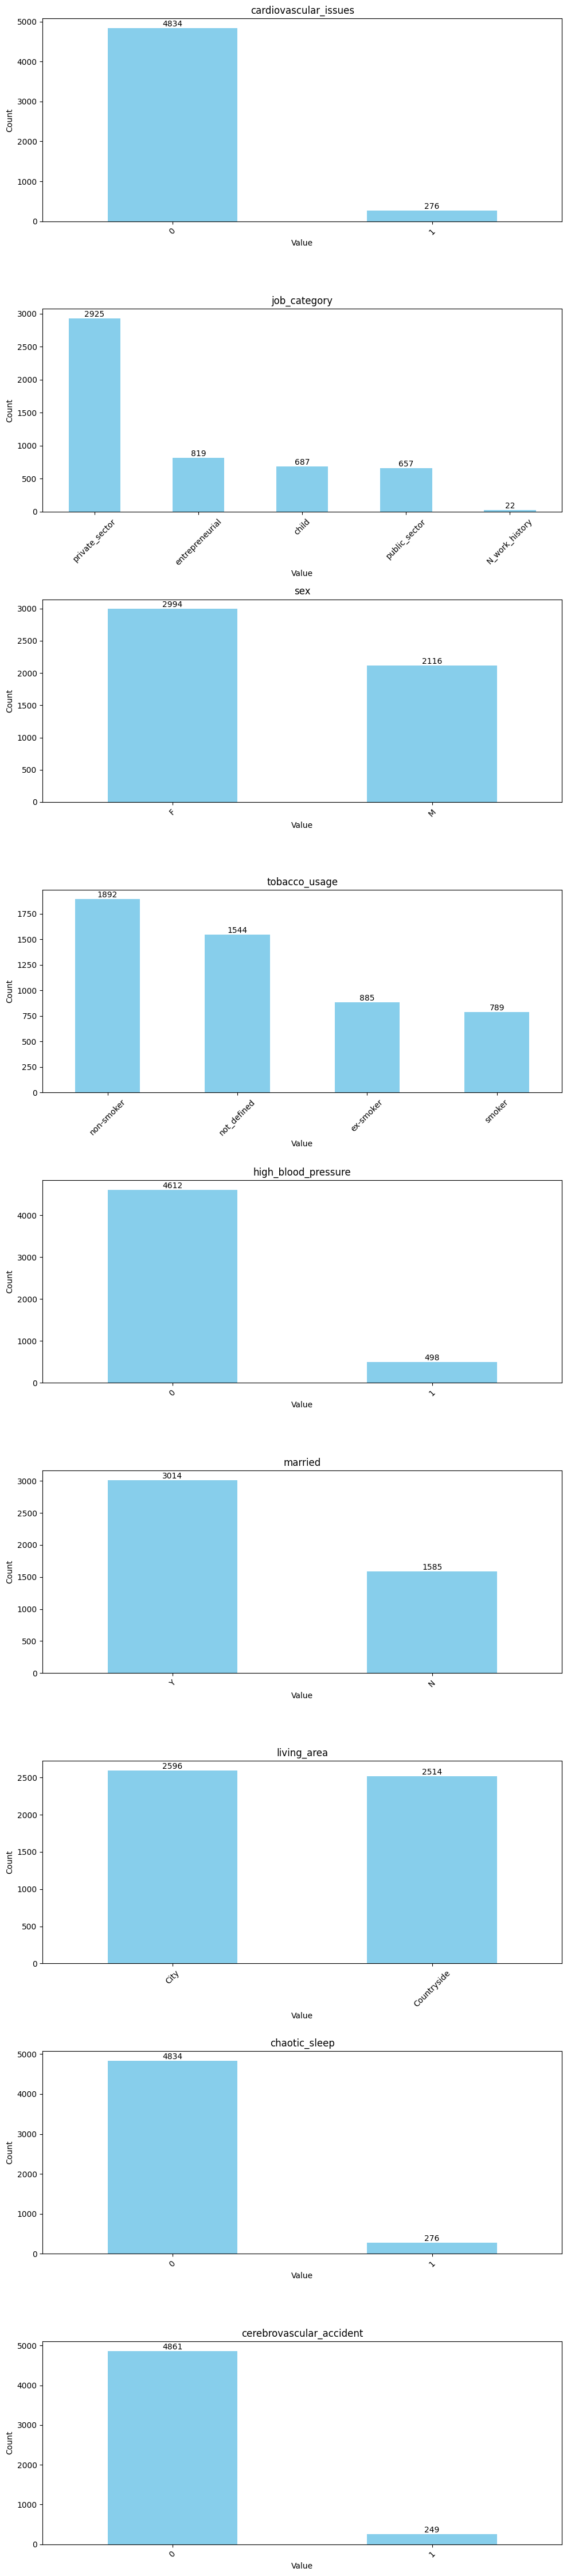

In [157]:
plot_category_features(avc_full_data, avc_category_features)

#### 1.2 Analiza echilibru de clase

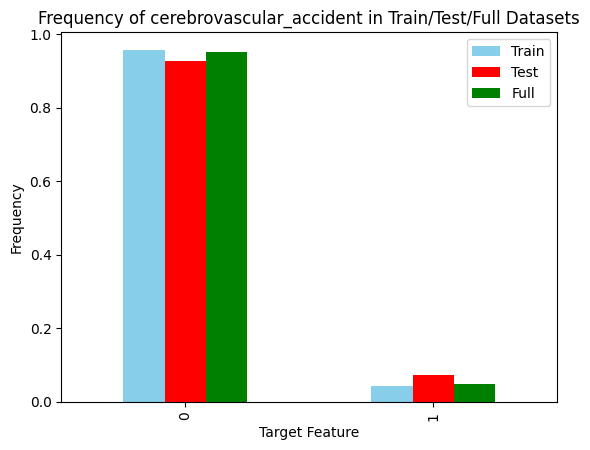

In [158]:
plot_target_feature(avc_train_data, avc_test_data, avc_full_data, avc_target_category)

#### 1.3 Analiza corelatiei intre atribute

#### 1.3a Atribute continue

,mean_blood_sugar_level,body_mass_indicator,years_old,analysis_results,biological_age_index
mean_blood_sugar_level,1.000000,0.175502,0.193335,0.894289,0.213950
body_mass_indicator,0.175502,1.000000,0.269022,0.157301,0.291308
years_old,0.193335,0.269022,1.000000,0.189087,0.714135
analysis_results,0.894289,0.157301,0.189087,1.000000,0.206042
biological_age_index,0.213950,0.291308,0.714135,0.206042,1.000000


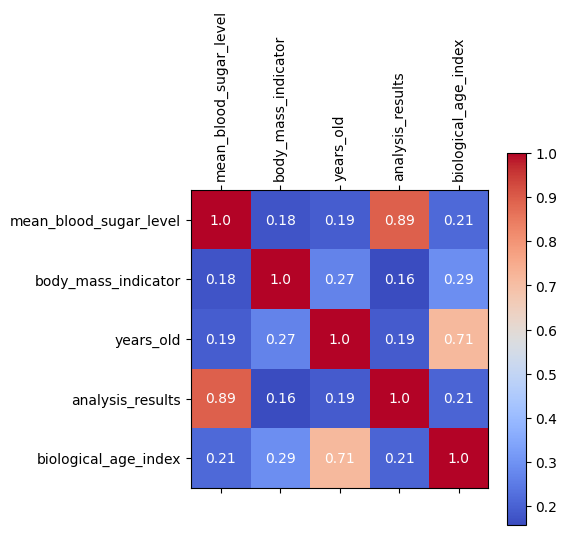

In [159]:
plot_correlation_continuous_data(avc_full_data[avc_continuous_features])

#### 1.3a Atribute discrete

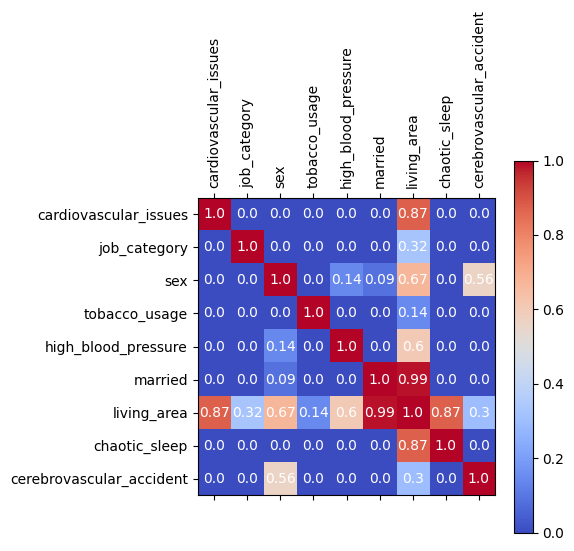

In [160]:
plot_correlation_category_data(avc_full_data[avc_category_features])

### SalaryPrediction

In [161]:
# Load the data
sp_full_data : pd.DataFrame = pd.read_csv('data/SalaryPrediction_full.csv')
sp_train_data : pd.DataFrame = pd.read_csv('data/SalaryPrediction_train.csv')
sp_test_data : pd.DataFrame = pd.read_csv('data/SalaryPrediction_test.csv')

# Show the data
sp_full_data.head()

,fnl,hpw,relation,gain,country,job,edu_int,years,loss,work_type,partner,edu,gender,race,prod,gtype,money
0,264627,40.0,NotM,0,United-States,Adm-clerical,10,38,0,Priv,D,SC,NaN,White,77,DC,<=50K
1,151369,40.0,NotF,0,United-States,Craft-repair,9,62,0,LGov,NM,HSG,M,White,87,AC,<=50K
2,188615,60.0,H,0,United-States,Sales,13,42,0,SelfInc,MCS,B,M,White,77,AC,>50K
3,151089,55.0,H,0,United-States,Exec-managerial,10,41,2415,SelfInc,MCS,SC,M,White,107,AC,>50K
4,177625,40.0,NotF,0,United-States,Machine-op-inspct,9,25,0,Priv,NM,HSG,M,White,57,AC,<=50K


In [162]:
# Data types

sp_continuous_features : list[str] = ['fnl', 'hpw', 'gain', 'edu_int', 'years', 'loss', 'prod']
sp_category_features : list[str] = ['relation', 'country', 'job', 'work_type', 'partner', 'edu', 'gender', 'race', 'gtype', 'money']

sp_target_category = 'money'


#### 1.1 Analiza tipului de atribute și a plajei de valori a acestora

##### 1.1a Atribute continue

In [163]:
display(sp_full_data[sp_continuous_features].describe())

,fnl,hpw,gain,edu_int,years,loss,prod
count,9.999000e+03,9199.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,1.903529e+05,40.416241,979.853385,14.262026,38.646865,84.111411,2014.927593
std,1.060709e+05,12.517356,7003.795382,24.770835,13.745101,394.035484,14007.604496
min,1.921400e+04,1.000000,0.000000,1.000000,17.000000,0.000000,-28.000000
25%,1.182825e+05,40.000000,0.000000,9.000000,28.000000,0.000000,42.000000
50%,1.784720e+05,40.000000,0.000000,10.000000,37.000000,0.000000,57.000000
75%,2.373110e+05,45.000000,0.000000,13.000000,48.000000,0.000000,77.000000
max,1.455435e+06,99.000000,99999.000000,206.000000,90.000000,3770.000000,200125.000000


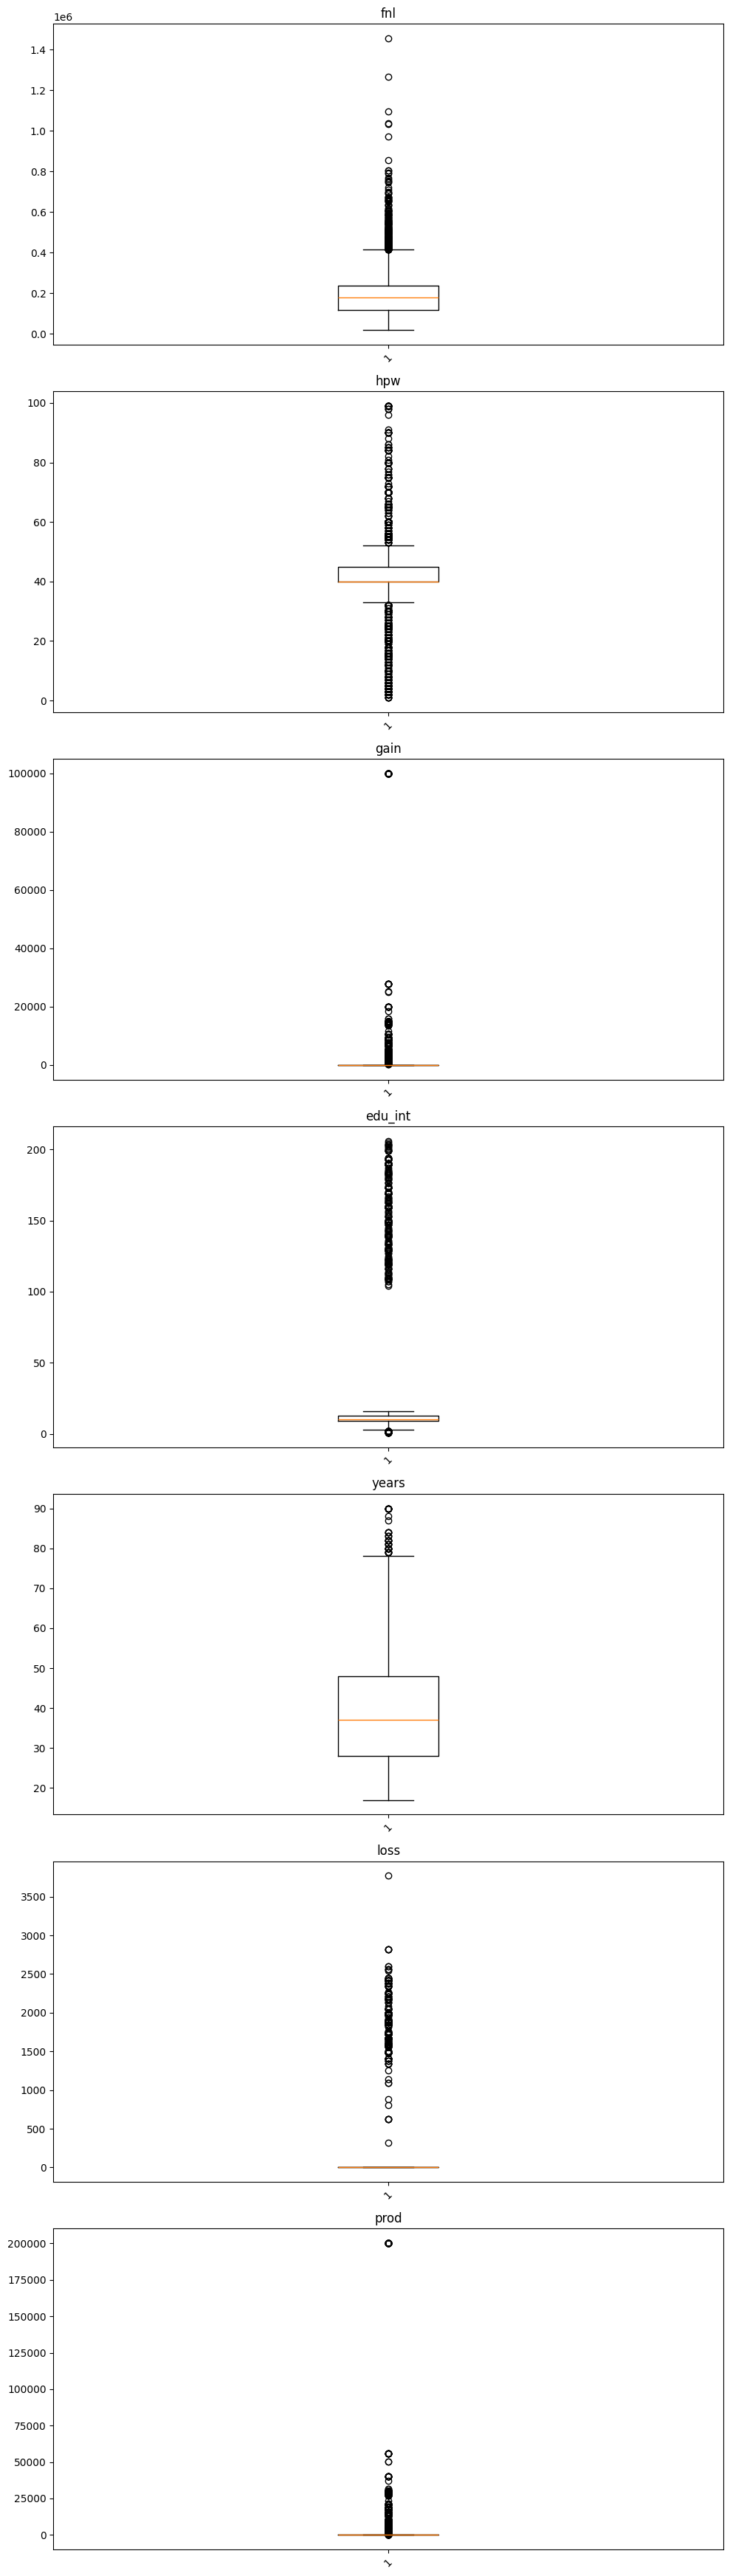

In [164]:
show_boxplot(sp_full_data, sp_continuous_features)

##### 1.1b Atribute discrete

In [165]:
display(pd.DataFrame({'count': sp_full_data[sp_category_features].count(),
                      'unique': sp_full_data[sp_category_features].nunique()}))

,count,unique
relation,9999,6
country,9999,41
job,9999,14
work_type,9999,9
partner,9999,7
edu,9999,16
gender,9199,2
race,9999,5
gtype,9999,2
money,9999,2


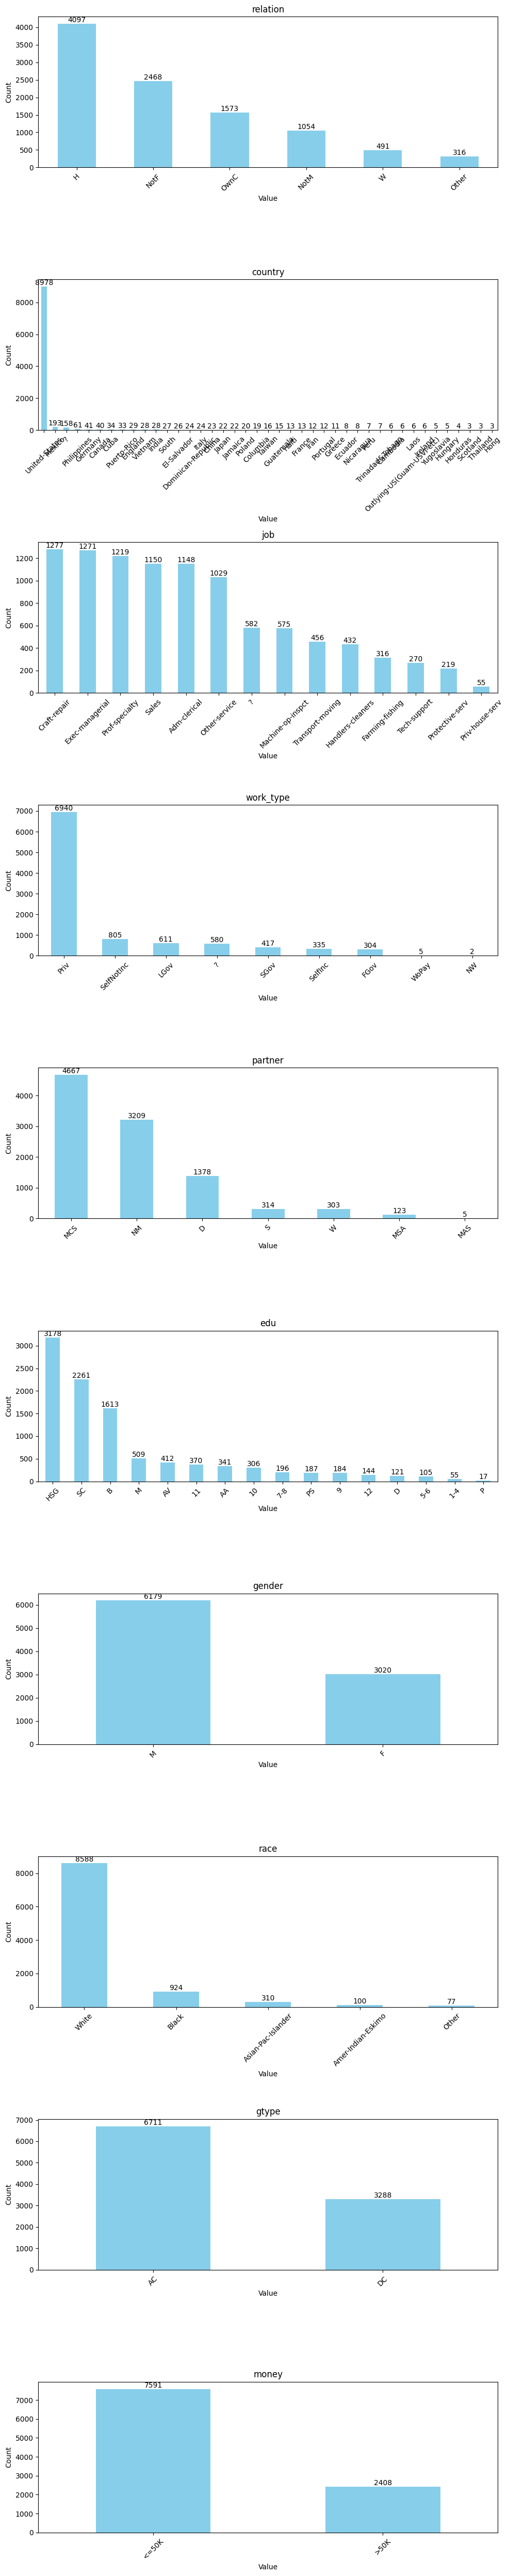

In [166]:
plot_category_features(sp_full_data, sp_category_features)

#### 1.2 Analiza echilibru de clase

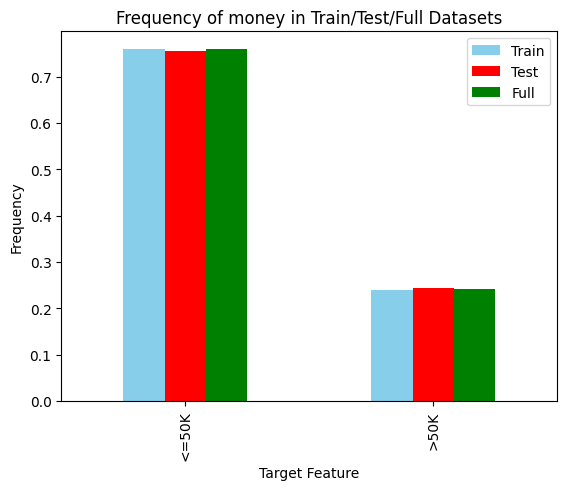

In [167]:
plot_target_feature(sp_train_data, sp_test_data, sp_full_data, sp_target_category)

#### 1.3 Analiza corelatiei intre atribute

#### 1.3a Atribute continue

,fnl,hpw,gain,edu_int,years,loss,prod
fnl,1.000000,-0.025606,0.003962,0.016926,-0.070322,-0.011453,0.003947
hpw,-0.025606,1.000000,0.096572,0.016341,0.068075,0.047413,0.096577
gain,0.003962,0.096572,1.000000,0.012155,0.084114,-0.029867,0.999998
edu_int,0.016926,0.016341,0.012155,1.000000,-0.001159,0.001615,0.012153
years,-0.070322,0.068075,0.084114,-0.001159,1.000000,0.045777,0.084161
loss,-0.011453,0.047413,-0.029867,0.001615,0.045777,1.000000,-0.029856
prod,0.003947,0.096577,0.999998,0.012153,0.084161,-0.029856,1.000000


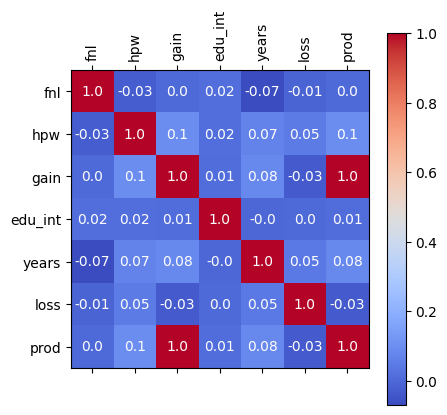

In [168]:
plot_correlation_continuous_data(sp_full_data[sp_continuous_features])

#### 1.3a Atribute discrete

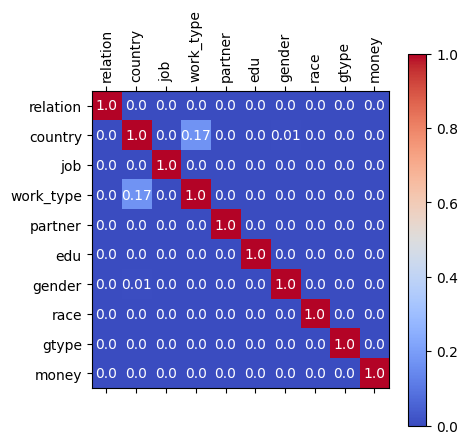

In [169]:
plot_correlation_category_data(sp_full_data[sp_category_features])

## 2. Preprocesarea datelor

### Utils

In [170]:
def replace_outliers_with_nan(data: pd.DataFrame, features: list[str], threshold: float = 3):
    for feature in features:
        z_scores = sp.stats.zscore(data[feature])
        data.loc[np.abs(z_scores) > threshold, feature] = np.nan
    return data

In [171]:
def replace_nan_with_median(data: pd.DataFrame, features: list[str]):
    imputer = imp.SimpleImputer(strategy='median')
    data[features] = imputer.fit_transform(data[features])
    return data

In [172]:
def remove_small_sample_categories(data: pd.DataFrame, features: list[str], threshold: float = 0.01):
    for feature in features:
        value_counts = data[feature].value_counts(normalize=True)
        to_remove = value_counts[value_counts < threshold].index # type: ignore
        data.loc[data[feature].isin(to_remove), feature] = np.nan
    return data

In [173]:
def replace_nan_with_missing(data: pd.DataFrame, features: list[str]):
    data[features] = data[features].fillna('?')
    return data

In [174]:
def scale_data(data: pd.DataFrame, features: list[str]):
    scaler = pre.StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    return data

In [175]:
def preprocess_data(data: pd.DataFrame, continuous_features: list[str], category_features: list[str], redundant_features: list[str] = []):
    data = data.copy()
    
    category_features = list(set(category_features) - set(redundant_features))
    continuous_features = list(set(continuous_features) - set(redundant_features))
    data = data.drop(redundant_features, axis=1)

    data = data.drop_duplicates()

    data = replace_outliers_with_nan(data, continuous_features)
    data = replace_nan_with_median(data, continuous_features)
    
    data = remove_small_sample_categories(data, category_features)
    data = replace_nan_with_missing(data, category_features)
    
    data[category_features].astype('category')
    
    data = scale_data(data, continuous_features)

    return data

### AVC

In [176]:
redundant_features = ['analysis_results', 'living_area']

pre_avc_category_features = [feature for feature in avc_category_features if feature not in redundant_features]
pre_avc_continuous_features = [feature for feature in avc_continuous_features if feature not in redundant_features]

pre_avc_full_data = preprocess_data(avc_full_data, pre_avc_continuous_features, pre_avc_category_features, redundant_features)
pre_avc_train_data = preprocess_data(avc_train_data, pre_avc_continuous_features, pre_avc_category_features, redundant_features)
pre_avc_test_data = preprocess_data(avc_test_data, pre_avc_continuous_features, pre_avc_category_features, redundant_features)

### SalaryPrediction

In [177]:
redundant_features = ['prod']

pre_sp_category_features = [feature for feature in sp_category_features if feature not in redundant_features]
pre_sp_continuous_features = [feature for feature in sp_continuous_features if feature not in redundant_features]

pre_sp_full_data = preprocess_data(sp_full_data, sp_continuous_features, sp_category_features, redundant_features)
pre_sp_train_data = preprocess_data(sp_train_data, sp_continuous_features, sp_category_features, redundant_features)
pre_sp_test_data = preprocess_data(sp_test_data, sp_continuous_features, sp_category_features, redundant_features)

## 3. Model Utils

In [178]:

class Model(base.BaseEstimator):
    def fit(self, X, y):
        raise NotImplementedError
    
    def predict(self, X):
        raise NotImplementedError
    
    def plot(self):
        raise NotImplementedError
    
    def score(self, X, y):
        raise NotImplementedError

In [179]:
def find_best_hyperparameters(model: Model, train_data: pd.DataFrame,
                              test_data: pd.DataFrame, target_feature: str, hyperparameters: dict,
                              cv: int = 5, balance: bool = False):
    train_data = train_data.copy()
    test_data = test_data.copy()

    encoder = pre.LabelEncoder()

    combined_data = pd.concat([train_data, test_data])    
    combined_data[target_feature] = encoder.fit_transform(combined_data[target_feature])
    combined_data = pd.get_dummies(combined_data, dtype='float64')
    train_data = combined_data[:len(train_data)]
    test_data = combined_data[len(train_data):]
    
    if balance:
        oversampler = over.RandomOverSampler(random_state=42)
        X = train_data.drop(target_feature, axis=1)
        y = train_data[target_feature]
        X, y = oversampler.fit_resample(X, y) # type: ignore
        train_data = pd.concat([X, y], axis=1)

    X = train_data.drop(target_feature, axis=1)
    y = train_data[target_feature]

    grid_search = ms.GridSearchCV(model, hyperparameters, verbose=1, cv=cv)

    grid_search.fit(X, y)

    return grid_search.best_params_

In [180]:
def apply_model(train_data : pd.DataFrame, 
                test_data : pd.DataFrame,
                target_feature: str, model : Model,
                balance = False):
    train_data = train_data.copy()
    test_data = test_data.copy()

    encoder = pre.LabelEncoder()

    combined_data = pd.concat([train_data, test_data])    
    combined_data[target_feature] = encoder.fit_transform(combined_data[target_feature])
    combined_data = pd.get_dummies(combined_data, dtype='float64')
    train_data = combined_data[:len(train_data)]
    test_data = combined_data[len(train_data):]
    
    if balance:
        oversampler = over.RandomOverSampler(random_state=42)
        X = train_data.drop(target_feature, axis=1)
        y = train_data[target_feature]
        X, y = oversampler.fit_resample(X, y) # type: ignore
        train_data = pd.concat([X, y], axis=1)

    X = train_data.drop(target_feature, axis=1)
    y = train_data[target_feature]

    model.fit(X, y)

    X = test_data.drop(target_feature, axis=1)

    predictions = np.round(model.predict(X))
    actual_results = encoder.inverse_transform(test_data[target_feature].astype(np.int64))
    results = encoder.inverse_transform(predictions.astype(int))
    results = pd.DataFrame({'actual': actual_results, 'predicted': results})

    return results

In [181]:
def show_confusion_matrix(results: pd.DataFrame, target_feature: str):
    confusion_matrix = pd.crosstab(results['actual'], results['predicted'])
    plt.matshow(confusion_matrix, cmap='coolwarm')
    plt.xticks(range(len(confusion_matrix.columns)), confusion_matrix.columns.to_list(), rotation=90)
    plt.yticks(range(len(confusion_matrix.columns)), confusion_matrix.columns.to_list())
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    for i in range(len(confusion_matrix.columns)):
        for j in range(len(confusion_matrix.columns)):
            plt.text(i, j, str(confusion_matrix.iloc[i, j].round(2)), ha='center', va='center', color='w') # type: ignore
    plt.show()

In [182]:
def compute_metrics(results: pd.DataFrame):
    accuracy = met.accuracy_score(results['actual'], results['predicted'])
    precision = met.precision_score(results['actual'], results['predicted'], average='macro', zero_division=0)
    recall = met.recall_score(results['actual'], results['predicted'], average='macro', zero_division=0)
    f1 = met.f1_score(results['actual'], results['predicted'], average='macro', zero_division=0)
    
    metrics = {'Accuracy': accuracy,
               'Precision' : precision,
               'Recall': recall,
               'F1': f1}

    return metrics

## 4. Regresie Logistica

### Utils

In [183]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    fig, (ax1, ax2) = plt.subplots(2,1)

    ax1.plot(range(epochs_no), train_acc, label="Train Accuracy", color="green")
    ax1.plot(range(epochs_no), test_acc, label="Test Accuracy", color="red")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    ax2.plot(range(epochs_no), train_nll, label="Train NLL", color="green")
    ax2.plot(range(epochs_no), test_nll, label="Test NLL", color="red")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)
    
    plt.show()

In [184]:
class LabLogisticRegression(Model):
    def __init__(self, learning_rate=0.01, epochs=100, test_size=0.2):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.test_size = test_size
        self.train_acc, self.test_acc = [], []
        self.train_nll, self.test_nll = [], []
    
    @staticmethod
    def _logistic(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def _accuracy(Y, T):
        N = Y.shape[0]
        return np.sum(np.round(Y) == T) / N
    
    @staticmethod
    def _nll(Y, T):
        N = T.shape[0]
        t_n = T * np.log(Y)
        t_1_n = (1 - T) * np.log(1 - Y + 1e-7)
        return (-1 / N) * np.sum(t_n + t_1_n)
    
    @staticmethod
    def _predict_logistic(X, w):
        N = X.shape[0]
        dot_product = np.dot(X, w)
        return LabLogisticRegression._logistic(dot_product)

    def fit(self, X, y):
        (N, D) = X.shape
        X = X.values
        y = y.values

        X_train, X_test, T_train, T_test = ms.train_test_split(X, y, test_size=self.test_size, stratify=y, random_state=42)
        
        self.w = np.random.randn(D)
        
        self.train_acc, self.test_acc = [], []
        self.train_nll, self.test_nll = [], []

        for _ in range(self.epochs):
            Y_train = self._predict_logistic(X_train, self.w)
            Y_test = self._predict_logistic(X_test, self.w)

            self.train_acc.append(self._accuracy(Y_train, T_train))
            self.test_acc.append(self._accuracy(Y_test, T_test))
            
            self.train_nll.append(self._nll(Y_train, T_train))
            self.test_nll.append(self._nll(Y_test, T_test))
            
            gradient = (1 / N) * np.dot(X_train.T, Y_train - T_train)
            self.w = self.w - self.learning_rate * gradient
    
    def predict(self, X):
        X = X.values
        return self._predict_logistic(X, self.w)
    
    def plot(self):
        plot_evolution(self.train_acc, self.test_acc, self.train_nll, self.test_nll)

    def score(self, X, y):
        y_pred = self.predict(X)
        return met.precision_score(y, np.round(y_pred), average='macro', zero_division=0)


In [185]:
class SkLearnLogisticRegression(Model):
    def __init__(self, epochs=100):
        self.epochs = epochs

    def fit(self, X, y):
        self.model = lm.LogisticRegression(max_iter=self.epochs)
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return met.precision_score(y, np.round(y_pred), average='macro', zero_division=0)

In [186]:
combined_metrics = {}

### AVC

#### Implementare Lab

In [187]:
if False:
    param_grid = {
        'epochs': [100, 300, 500, 800, 1000, 1200, 1500],
        'learning_rate': [0.001, 0.01, 0.1, 0.2]
    }

    best_params = find_best_hyperparameters(LabLogisticRegression(), pre_avc_train_data, pre_avc_test_data, avc_target_category, param_grid, balance=True)
    print(best_params)
'''
{'epochs': 1500, 'learning_rate': 0.1}
'''

"\n{'epochs': 1500, 'learning_rate': 0.1}\n"

{'Accuracy': 0.7446183953033269,
 'Precision': 0.5774136577708007,
 'Recall': 0.7332840549102428,
 'F1': 0.5684310156534401}

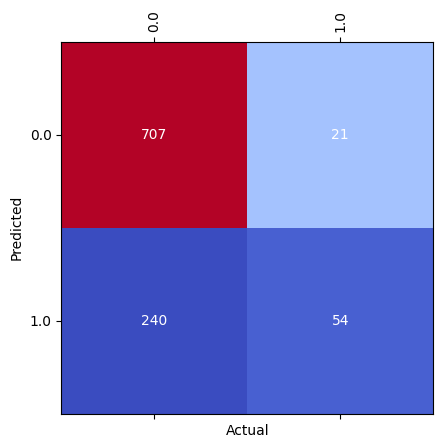

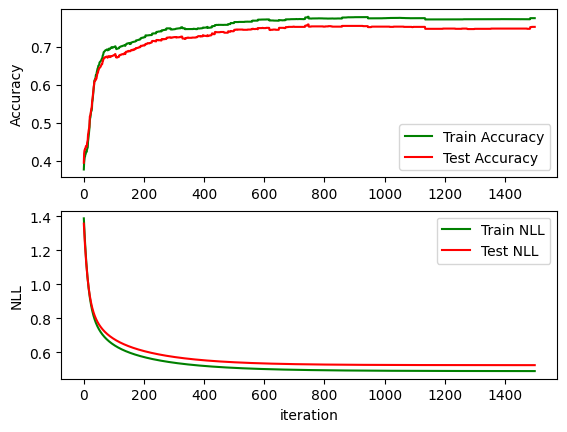

In [188]:
best_params = {'epochs': 1500, 'learning_rate': 0.1}

model = LabLogisticRegression(**best_params)
results = apply_model(pre_avc_train_data, 
                      pre_avc_test_data,
                      avc_target_category, 
                      model, balance = True)
metrics = compute_metrics(results)
combined_metrics['AVC_Lab_Logistic_Regression'] = metrics
display(combined_metrics['AVC_Lab_Logistic_Regression'])
show_confusion_matrix(results, avc_target_category)
model.plot()

#### SkLearn

In [189]:
if False:
    param_grid = {
        'epochs': [100, 300, 500, 800, 1000, 1200, 1500],
    }

    best_params = find_best_hyperparameters(SkLearnLogisticRegression(), pre_avc_train_data, pre_avc_test_data, avc_target_category, param_grid, balance=True)
    print(best_params)
'''
{'epochs': 100}
'''

"\n{'epochs': 100}\n"

{'Accuracy': 0.7446183953033269,
 'Precision': 0.5774136577708007,
 'Recall': 0.7332840549102428,
 'F1': 0.5684310156534401}

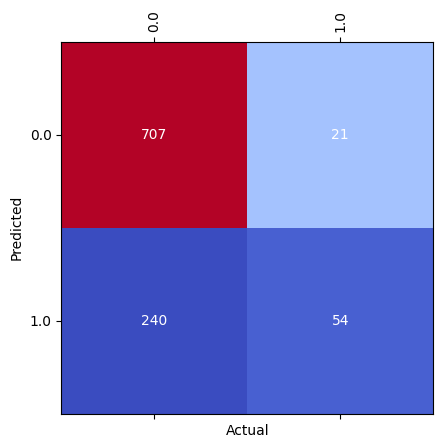

In [190]:
best_params = {'epochs': 100}

model = SkLearnLogisticRegression(**best_params)
results = apply_model(pre_avc_train_data, 
                      pre_avc_test_data,
                      avc_target_category, 
                      model, balance = True)
metrics = compute_metrics(results)
combined_metrics['AVC_Sklearn_Logistic_Regression'] = metrics
display(combined_metrics['AVC_Sklearn_Logistic_Regression'])
show_confusion_matrix(results, avc_target_category)

### SalaryPrediction

#### Implementare Lab

In [191]:
if False:
    param_grid = {
        'epochs': [100, 300, 500, 800, 1000, 1200, 1500],
        'learning_rate': [0.001, 0.01, 0.1, 0.2]
    }

    best_params = find_best_hyperparameters(LabLogisticRegression(), pre_sp_train_data, pre_sp_test_data, sp_target_category, param_grid, balance=False)
    print(best_params)
'''
{'epochs': 1500, 'learning_rate': 0.2}
'''

"\n{'epochs': 1500, 'learning_rate': 0.2}\n"

{'Accuracy': 0.83,
 'Precision': 0.7781640247699271,
 'Recall': 0.7309898742045327,
 'F1': 0.7490315570672714}

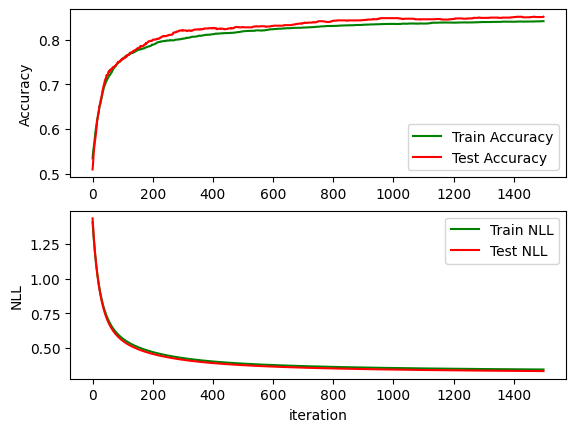

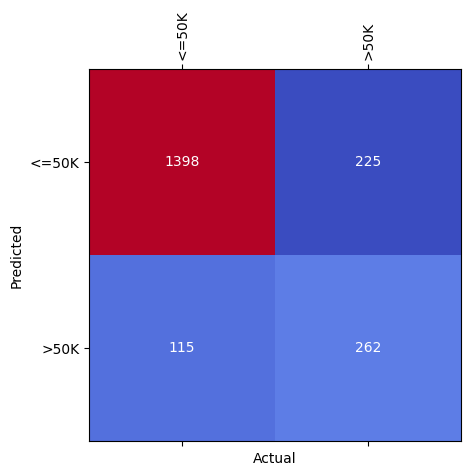

In [192]:
best_params = {'epochs': 1500, 'learning_rate': 0.2}

model = LabLogisticRegression(**best_params)
results = apply_model(pre_sp_train_data,
                                          pre_sp_test_data,
                                          sp_target_category,
                                          model, balance = False)
metrics = compute_metrics(results)
combined_metrics['SP_Lab_Logistic_Regression'] = metrics
display(combined_metrics['SP_Lab_Logistic_Regression'])
model.plot()
show_confusion_matrix(results, sp_target_category)

#### Sklearn

In [193]:
if True:
    param_grid = {
        'epochs': [100, 300, 500, 800, 1000, 1200, 1500],
    }

    best_params = find_best_hyperparameters(SkLearnLogisticRegression(), pre_sp_train_data, pre_sp_test_data, sp_target_category, param_grid, balance=False)
    print(best_params)
'''
{'epochs': 100}
'''

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'epochs': 100}


"\n{'epochs': 100}\n"

{'Accuracy': 0.9246575342465754,
 'Precision': 0.4632352941176471,
 'Recall': 0.4989440337909187,
 'F1': 0.4804270462633452}

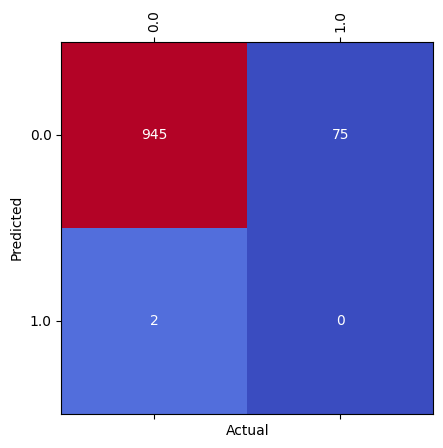

In [194]:
best_params = {'epochs': 100}

model = SkLearnLogisticRegression(**best_params)
results = apply_model(pre_avc_train_data, 
                      pre_avc_test_data,
                      avc_target_category, 
                      model, balance = False)
metrics = compute_metrics(results)
combined_metrics['SP_Sklearn_Logistic_Regression'] = metrics
display(combined_metrics['SP_Sklearn_Logistic_Regression'])
show_confusion_matrix(results, avc_target_category)

## 5. MLP

### Utils

In [195]:
class Layer:
    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass

In [196]:

class FeedForwardNetwork:
    def __init__(self, layers: tp.List[Layer]):
        self.layers = layers

    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x

    def backward(self, dy: np.ndarray) -> np.ndarray:
        for i, layer in reversed(list(enumerate(self.layers))):
            dy = layer.backward(self._inputs[i], dy)
        return dy

    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

In [197]:
class Linear(Layer):
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
   
    def forward(self, x: np.ndarray) -> np.ndarray:
        return x @ self.weight + self.bias
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        self.dweight = x.T @ dy
        self.dbias = np.sum(dy, axis=0)
        return dy @ self.weight.T
    
    def update(self, lr=0.001, mu=0.9):
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias

In [198]:
class ReLU(Layer):
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(x, 0)
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        return dy * (x > 0)

In [199]:
class CrossEntropy:
    def __init__(self):
        pass
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps,axis = 1).reshape(-1,1)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        probs = self.softmax(y)
        return -np.mean(np.log(probs[np.arange(len(probs)), t]))
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        probs = self.softmax(y)
        probs[np.arange(len(probs)), t] -= 1
        return probs / len(t)


In [200]:
class LabMLP(Model):
    def __init__(self, learning_rate=0.01, epochs=1000, test_size=0.2, hidden_size=100, batch_size=32):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.test_size = test_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.train_acc, self.test_acc = [], []
        self.train_nll, self.test_nll = [], []

    def fit(self, X, y):
        (N, D) = X.shape
        X = X.values
        y = y.values

        X_train, X_test, T_train, T_test = ms.train_test_split(X, y, test_size=self.test_size, 
                                                               stratify=y, random_state=42)
        
        self.net = FeedForwardNetwork([
            Linear(D, self.hidden_size),
            ReLU(),
            Linear(self.hidden_size, 2)
        ])
        self.loss = CrossEntropy()

        self.train_acc, self.test_acc = [], []
        self.train_nll, self.test_nll = [], []

        for _ in range(self.epochs):
            for _, idx in enumerate(range(0, len(X_train), self.batch_size)):
                X_batch = X_train[idx:idx + self.batch_size]
                T_batch = T_train[idx:idx + self.batch_size]

                Y = self.net.forward(X_batch)
                loss = self.loss.forward(Y, T_batch)
                dY = self.loss.backward(Y, T_batch)
                self.net.backward(dY)
                self.net.update(self.learning_rate)

            self.train_nll.append(loss)
            self.train_acc.append(np.mean(np.argmax(Y, axis=1) == T_batch))
        
            self.test_acc.append(np.mean(np.argmax(self.net.forward(X_test), axis=1) == T_test))
            self.test_nll.append(self.loss.forward(self.net.forward(X_test), T_test))
            
    def predict(self, X):
        X = X.values
        return np.argmax(self.net.forward(X), axis=1)
    
    
    def plot(self):
        plot_evolution(self.train_acc, self.test_acc, self.train_nll, self.test_nll)
        
    def score(self, X, y):
        y_pred = self.predict(X)
        return met.precision_score(y, y_pred, average='macro', zero_division=0)

In [201]:
class SklearnMLP(Model):
    def __init__(self, epochs=100, hidden_size=100, batch_size=32):
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_nll, self.test_acc = [], []

    def fit(self, X, y):
        self.test_nll, self.test_acc = [], []
        
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        
        self.net = nn.MLPClassifier(hidden_layer_sizes=(self.hidden_size, ), max_iter=1, 
                                    warm_start=True, batch_size=self.batch_size)
        for _ in range(self.epochs):
            self.net.fit(X, y)
            self.test_acc.append(met.accuracy_score(y, self.net.predict(X)))
            self.test_nll.append(met.log_loss(y, self.net.predict_proba(X)))

    def predict(self, X):
        return self.net.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return met.precision_score(y, y_pred, average='macro', zero_division=0)
    
    def plot(self):
        epochs_no = len(self.test_acc)
        fig, (ax1, ax2) = plt.subplots(2,1)

        ax1.plot(range(epochs_no), self.test_acc, label="Test Accuracy", color="red")
        ax1.set_ylabel("Accuracy")
        ax1.legend(loc='lower right', ncol=1)

        ax2.plot(range(epochs_no), self.test_nll, label="Test NLL", color="red")
        ax2.set_xlabel("iteration")
        ax2.set_ylabel("NLL")
        ax2.legend(loc='upper right', ncol=1)
        
        plt.show()
        

### AVC

#### Implementare Lab

In [202]:
if False:
    param_grid = {
        'hidden_size': [80, 100, 120],
        'batch_size': [32, 64, 128, 256],
        'epochs': [100, 200, 300],
        'learning_rate': [0.001, 0.01]
    }

    best_params = find_best_hyperparameters(LabMLP(), pre_avc_train_data, pre_avc_test_data, avc_target_category, param_grid, balance=True)
    print(best_params)
'''
{'batch_size': 32, 'epochs': 300, 'hidden_size': 120}
'''

"\n{'batch_size': 32, 'epochs': 300, 'hidden_size': 120}\n"

{'Accuracy': 0.8776908023483366,
 'Precision': 0.5619028662420382,
 'Recall': 0.5656810982048575,
 'F1': 0.563687904506566}

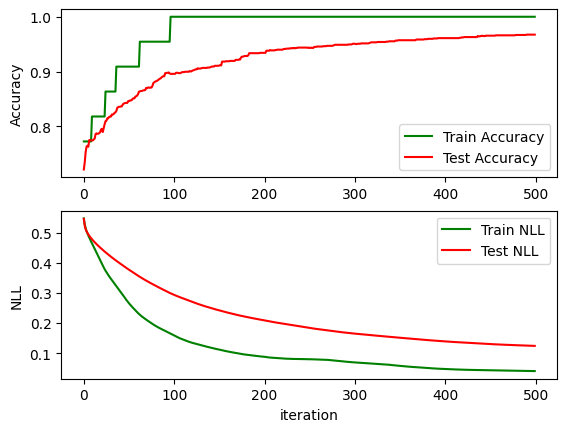

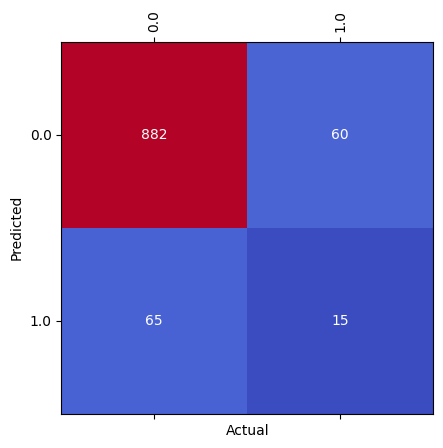

In [203]:
best_params = {'batch_size': 32, 'epochs': 500, 'hidden_size': 120}

model = LabMLP(**best_params)
results = apply_model(pre_avc_train_data, 
                      pre_avc_test_data,
                      avc_target_category, 
                      model, balance = True)
metrics = compute_metrics(results)
combined_metrics['AVC_Lab_MLP'] = metrics
display(combined_metrics['AVC_Lab_MLP'])
model.plot()
show_confusion_matrix(results, avc_target_category)

#### Sklearn

In [204]:
if False:
    param_grid = {
        'hidden_size': [80, 100, 120],
        'batch_size': [32, 64, 128, 256],
        'epochs': [100, 200, 300]
    }

    best_params = find_best_hyperparameters(SklearnMLP(), pre_avc_train_data, pre_avc_test_data, avc_target_category, param_grid, balance=True)
    print(best_params)
'''
{'batch_size': 32, 'epochs': 300, 'hidden_size': 120}
'''

"\n{'batch_size': 32, 'epochs': 300, 'hidden_size': 120}\n"

{'Accuracy': 0.8835616438356164,
 'Precision': 0.5178571428571429,
 'Recall': 0.5136008447729673,
 'F1': 0.5146985471043842}

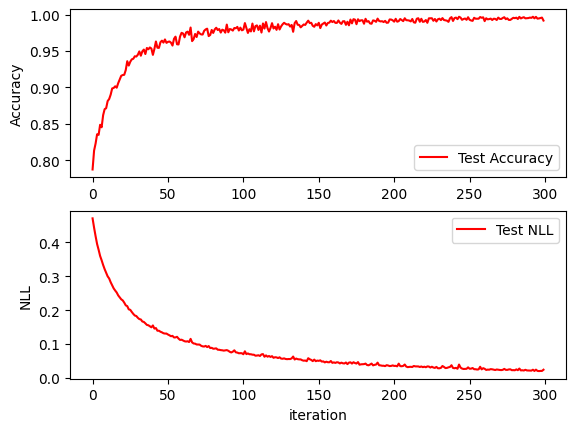

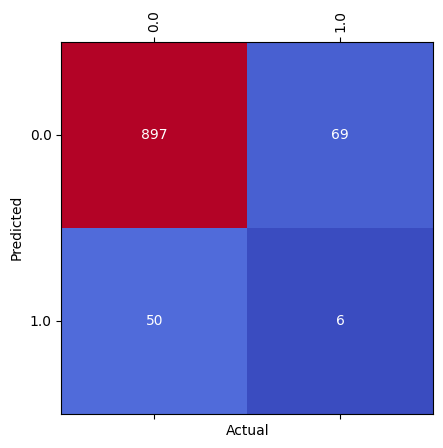

In [205]:
best_params = {'batch_size': 32, 'epochs': 300, 'hidden_size': 120}

model = SklearnMLP(**best_params)
results = apply_model(pre_avc_train_data, 
                      pre_avc_test_data,
                      avc_target_category, 
                      model, balance = True)
metrics = compute_metrics(results)
combined_metrics['AVC_Sklearn_MLP'] = metrics
display(combined_metrics['AVC_Sklearn_MLP'])
model.plot()
show_confusion_matrix(results, avc_target_category)

### SalaryPrediction

#### Implementare Lab

In [206]:
if False:
    param_grid = {
        'hidden_size': [80, 100, 120],
        'batch_size': [32, 64, 128, 256],
        'epochs': [100, 200, 300],
        'learning_rate': [0.001, 0.01]
        
    }

    best_params = find_best_hyperparameters(LabMLP(), pre_sp_train_data, pre_sp_test_data, sp_target_category, param_grid, balance=False)
    print(best_params)
'''
{'batch_size': 32, 'epochs': 100, 'hidden_size': 100, 'learning_rate': 0.01}
'''

"\n{'batch_size': 32, 'epochs': 100, 'hidden_size': 100, 'learning_rate': 0.01}\n"

{'Accuracy': 0.852,
 'Precision': 0.8100774523838332,
 'Recall': 0.7678097148464166,
 'F1': 0.7850823947629807}

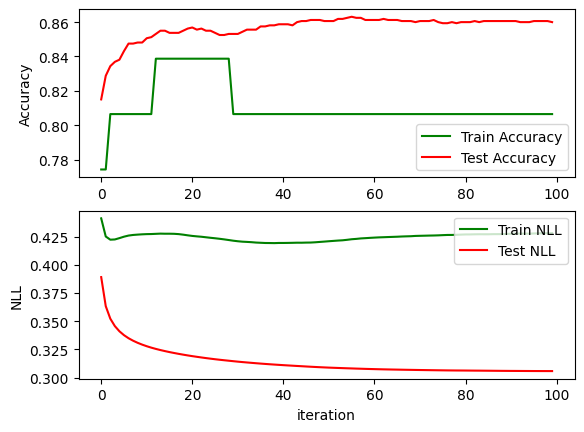

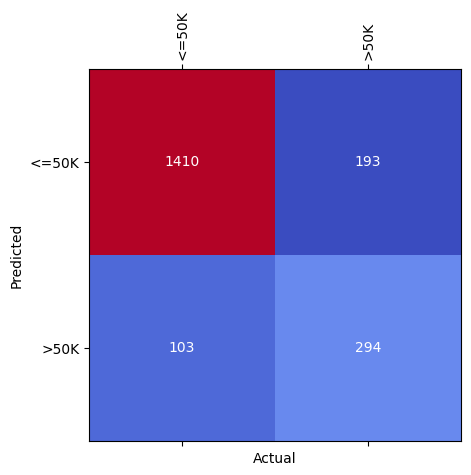

In [207]:
best_params = {'batch_size': 32, 'epochs': 100, 'hidden_size': 100, 'learning_rate': 0.01}

model = LabMLP(**best_params)
results = apply_model(pre_sp_train_data,
                      pre_sp_test_data,
                      sp_target_category,
                      model, balance = False)
metrics = compute_metrics(results)
combined_metrics['SP_Lab_MLP'] = metrics
display(combined_metrics['SP_Lab_MLP'])
model.plot()
show_confusion_matrix(results, sp_target_category)

#### Sklearn

In [208]:
if False:
    param_grid = {
        'hidden_size': [80, 100, 120],
        'batch_size': [32, 64, 128, 256],
        'epochs': [100, 200, 300]
    }

    best_params = find_best_hyperparameters(SklearnMLP(), pre_sp_train_data, pre_sp_test_data, sp_target_category, param_grid, balance=False)
    print(best_params)
'''
{'batch_size': 256, 'epochs': 100, 'hidden_size': 80}
'''

"\n{'batch_size': 256, 'epochs': 100, 'hidden_size': 80}\n"

{'Accuracy': 0.829,
 'Precision': 0.7718641258818593,
 'Recall': 0.7435572064693261,
 'F1': 0.7556081498250669}

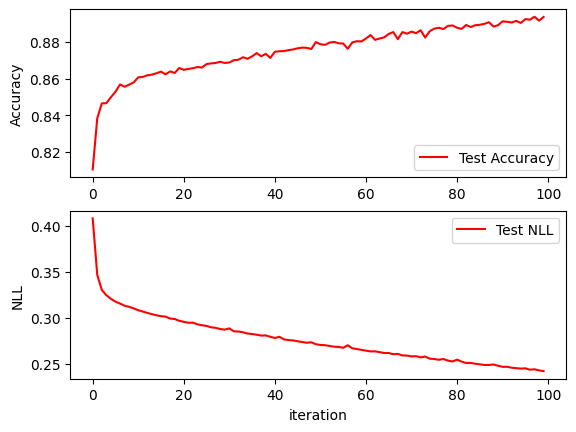

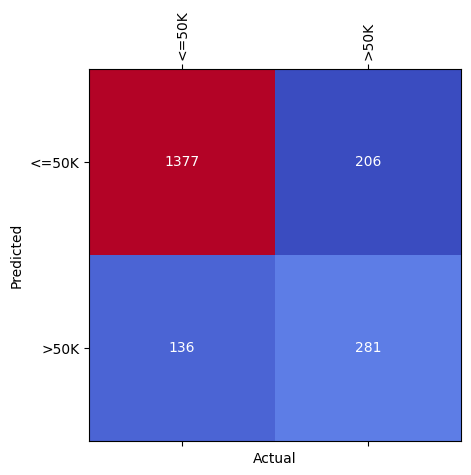

In [209]:
best_params = {'batch_size': 256, 'epochs': 100, 'hidden_size': 80}

model = SklearnMLP(**best_params)
results = apply_model(pre_sp_train_data,
                      pre_sp_test_data,
                      sp_target_category,
                      model, balance = False)
metrics = compute_metrics(results)
combined_metrics['SP_Sklearn_MLP'] = metrics
display(combined_metrics['SP_Sklearn_MLP'])
model.plot()
show_confusion_matrix(results, sp_target_category)

## 6. Concluzie

In [210]:
metrics_df = pd.DataFrame(combined_metrics)
display(metrics_df)

,AVC_Lab_Logistic_Regression,AVC_Sklearn_Logistic_Regression,SP_Lab_Logistic_Regression,SP_Sklearn_Logistic_Regression,AVC_Lab_MLP,AVC_Sklearn_MLP,SP_Lab_MLP,SP_Sklearn_MLP
Accuracy,0.744618,0.744618,0.830000,0.924658,0.877691,0.883562,0.852000,0.829000
Precision,0.577414,0.577414,0.778164,0.463235,0.561903,0.517857,0.810077,0.771864
Recall,0.733284,0.733284,0.730990,0.498944,0.565681,0.513601,0.767810,0.743557
F1,0.568431,0.568431,0.749032,0.480427,0.563688,0.514699,0.785082,0.755608
